# Web and Text Analytics - Sentiment Analysis

### Authors
- Francois Cubelier
- Lisa Bueres
- Romain Charles

## Introduction
This report showcases our results for sentiment analysis. We experimented different types of recurrent neural networks on this task: basic RNN, LSTM and GRU. We studied the effect of attention on these models as well as testing different word embeddings (GloVe, FastText and Word2Vec). Moreover, document level embeddings were also investigated (WME, Bert sentence, GloVe average and a task specific average). Finally, results were compared on the IMDB and Yelp reviews datasets.

### Sentiment Analysis
Sentiment analysis is the analysis of texts such as reviews in order to detect the polarity implied by the author. The polarity is either positive, negative or neutral. A more complex type of sentiment analysis is a multiclass one as in the Yelp reviews dataset which contains rating on 5 stars.

## Methods

### RNNs

3 types of recurrent neural networks were tested: Base RNN, LSTM and GRUs. We also experimented with different hyperparameters: 
- The number of hidden layers: 1 or 2
- The size of the hidden state: 100 or 300
- The type of output layer after the main network: linear or MLP (for more details on the MLP, see models/RNN.py)

### Attention
We tested 2 types of attention based on scaled dot-product attention: 
- Last hidden layer attention: 
$Attention(Q, K, V) = softmax(QK^\top/\sqrt n)V$ where V = K = output sequence and Q is the last hiddent state produced by the recurrent neural network.
- Self-attention followed by last hiddent layer attention.
First we apply a self attention:
$Attention_1(Q, K, V) = V' = softmax(QK^\top/\sqrt n)V$ where V = K = Q = output sequence.
Then we apply the last hidden layer attention:
$Attention_2(Q', K', V') = softmax(Q'K'^\top/\sqrt n)V'$ where V' = K' = output sequence of self-attention and Q is the last hidden state of the RNN.

### Word embedding

In our experiments, we tested 3 types of pre-trained word embeddings: GloVe, FastText and Word2Vec.


### Document level embeddings
There are numerous document level embeddings in the literature.
Four were tested here:
- Average glove embeddings: a sentence is encoded by the average of its GloVe word embeddings.
- Task specific average: a sentence is encoded by the average of its word embeddings and the word embedding are trained from scratch for this task jointly with the classifer.
- WME: Document embedding based on the distance (based on Word Mover Distance) between the document and randomly generated documents.
- Sentence BERT: a pre-trained document level embedding based on BERT (all-MiniLM-L6-v2 model).

In order to predict the class from the document embedding, 2 types of model were tested: linear model and MLP.

## Datasets
The dataset were downloaded from [torchtext](https://pytorch.org/text/stable/datasets.html#text-classification)
#### IMDB
The IMDB dataset contains 50000 reviews of films with their corresponding polarity (positive or negative) (25000 for the train set and 25000 for the test set).
#### Yelp reviews full
The Yelp review dataset contains 700000 reviews with their corresponding rating on 5 stars (650000 for the train set and 50000 for the test set)

## Experiments

### Experimental setup

For our experiments, we trained our model with Adam optimizer ($\beta_1 = 0.9, \beta_2=0.999)$) with a learning rate of $0.001$. For experiment 1 to 4, a batch size of 32 was used and 64 for experiment 5. 
We used early stopping, the validation loss was monitored during training (on 10% of the initial training set) and the training was stopped if there were no improvement during the last t epochs (t=4 for Exp.1 and 6 for the others) or if the maximal number of iterations had been reached. Later, the number of iterations is also called the number of steps. The last model is kept and is typically overfitted (except for experiment 5).

For the initial experiment, a vocabulary size of 10000 was used and 20000 for the remaining experiments. The GloVe pretrained embeddings are the glove.840B.300d ones. Word2Vec are pretrained 300 dimensional embeddings from Google news.

While the first experiment uses different hyperparameters for the RNNs, the others use a word embedding of size 300, a hidden dimension of 100, one hidden layer, a linear output layer, sentences are truncated at 580 words and GloVe embeddings are used by default.

For further details on the experiments, see the corresponding code.

In [1121]:
import pandas as pd
import seaborn as sns

## Experiment 1: Hyperparameters
In this experiment, we compare RNN, LSTM and GRU over the IMDB datasets and examine the results by varying hyperparameters.

In [1122]:
df_1 = pd.read_csv("results/exp1_all.csv")

#### Model
As can be seen by computing the mean of the test accuracy and the test loss, GRU and LSTM are better than RNN. GRU and LSTM have mean accuracies very close, GRU being slighty better than LSTM, but LSTM is able to better reduce the loss in average. RNN performed around 30% less than the others for the accuracy and the the loss, which is a non negligible difference.

Both GRU and LSTM use 'memory' while the simple RNN does not. This allows the two first to have more information than the RNN when performing the classification, explaining the difference in performance.

In [1123]:
df_1.groupby("Model Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Model Type,,
GRU,0.883545,0.446573
LSTM,0.880375,0.375391
RNN,0.548980,0.678701


<AxesSubplot:xlabel='Model Type', ylabel='Test Loss'>

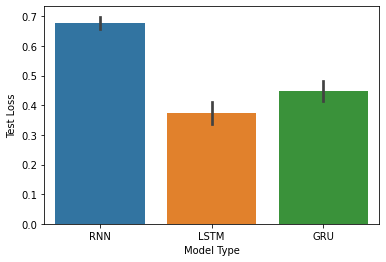

In [1124]:
sns.barplot(x="Model Type", y="Test Loss", data=df_1)

#### Output Layer Type
The table below shows that linear layers performed better than MLP, on both the accuracy and the loss. This is probably due to the Multi-Layer Perceptron (MLP) leading to a more complex model, with overfitting on the training set and thus reduced performance on the testing set, while the linear model is simpler and limited in overtfitting thanks to its structure not allowing too complex functions. Additionally, using a more complex model after the RNN may not force the RNN to learn a good representation of the sentence (not linearly separable).

In [1125]:
df_1.groupby("Output Layer Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Output Layer Type,,
MLP,0.759180,0.523465
linear,0.782753,0.476979


#### Number of layers
As shown in the table below, adding one layer slighlty improved the average accuracy and decreased the loss. However it also comes with an increase in computation time.

In [1126]:
df_1.groupby("Number of Layers").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Number of Layers,,
1,0.766113,0.506772
2,0.775820,0.493671


#### Number of features in the hidden state
Increasing the number of features in the hidden state (hidden size) leads to slightly less performance. This is shown in the table below where the size goes from 100 to 300. The average difference is tight as it is of around 2% for both the average accuracy and the average loss.

In [1127]:
df_1.groupby("Hidden Size").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Hidden Size,,
100,0.784587,0.483162
300,0.757347,0.517282


#### Full results
This table allowing to compare the results for all the hyper-parameters simultaneously corroborates what has been said previously. However, the effect of the number of layers is not clear: increasing from 1 to 2 sometimes increases the performance, sometimes decreases it.
But this table brings new information: the best test accuracy, 0.88768, is reached by the GRU model, with linear layer, a hidden size of 100 and two layers. This configuration has also the fourth smallest loss, which upholds the qualification as the best in the table. It converged in only 5632 steps. The minimal loss, 0.287417, is obtained by a LSTM model, also linear with 100 features and 1 layer. The test accuracy is also the third better, thus making this combination of parameters a pretty good choice too. The number of steps reaches 6336 this time, meaning more computation time. Without distinguishing the model, the hyper parameters of those two combinations are the same.

At the opposite, the worst performances are obtained with the basic RNN, far from LSTM and GRU. The worst accuracy, 0.49788, is the RNN-linear with a size of 300 and 2 layers. The highest loss, 0.722325, is achieved with the RNN-linear, with a size of 300 and 1 layer.

We can see that the number of steps required for the LSTM is generally higher than the ones of GRU and RNN with values at 6336 or above up to 8448, while the RNN has the smallest at 4224 and GRU at 4928.

In [1128]:
df_1.groupby(["Model Type", "Hidden Size", "Number of Layers", "Output Layer Type"], sort=True).max()[["Test Acc", "Test Loss", "step"]]

Test Acc  \
Model Type Hidden Size Number of Layers Output Layer Type             
GRU        100         1                MLP                 0.88512   
                                        linear              0.88768   
                       2                MLP                 0.87712   
                                        linear              0.88440   
           300         1                MLP                 0.88096   
                                        linear              0.88564   
                       2                MLP                 0.88552   
                                        linear              0.88192   
LSTM       100         1                MLP                 0.87304   
                                        linear              0.88560   
                       2                MLP                 0.87956   
                                        linear              0.87576   
           300         1                MLP                 0.87700   
                                        linear              0.88392   
                       2                MLP                 0.88324   
                                        linear              0.88488   
RNN        100         1                MLP                 0.50516   
                                        linear              0.60004   
                       2                MLP                 0.56544   
                                        linear              0.69612   
           300         1                MLP                 0.50000   
                                        linear              0.52920   
                       2                MLP                 0.49800   
                                        linear              0.49788   

                                                           Test Loss  step  
Model Type Hidden Size Number of Layers Output Layer Type                   
GRU        100         1                MLP                 0.423704  7744  
                                        linear              0.348002  5632  
                       2                MLP                 0.475683  6336  
                                        linear              0.444155  7040  
           300         1                MLP                 0.523954  5632  
                                        linear              0.482910  5632  
                       2                MLP                 0.436582  6336  
                                        linear              0.437592  4928  
LSTM       100         1                MLP                 0.462807  8448  
                                        linear              0.287417  6336  
                       2                MLP                 0.410049  8448  
                                        linear              0.326734  7040  
           300         1                MLP                 0.410662  6336  
                                        linear              0.383310  7040  
                       2                MLP                 0.392338  7040  
                                        linear              0.329815  6336  
RNN        100         1                MLP                 0.689820  4224  
                                        linear              0.652205  8448  
                       2                MLP                 0.667698  5632  
                                        linear              0.609671  4928  
           300         1                MLP                 0.694153  5632  
                                        linear              0.722325  7040  
                       2                MLP                 0.694128  3520  
                                        linear              0.699611  5632

#### Validation Loss monitoring
One can see that the RNN does not learn much. Both the LSTM and the GRU do overfit the training set but the GRU reaches its minimal loss in less iterations than LSTM.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

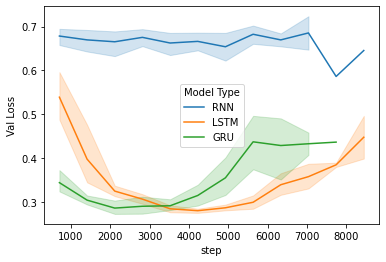

In [1129]:
sns.lineplot(x="step", y="Val Loss", hue="Model Type", data=df_1)

#### Distribution of the loss and the accuracy
For the accuracy, we can see that the RNN is highly spread, with a mean of around 0.55. Some RNN achieved better results, but those are not significant. The accuracies of the LSTM and GRU model are at the opposite very tight around their mean, which was of 0.88.
For the loss, the one of the RNN model is moderately spread, but the mean is high. The losses of LSTM and GRU are a bit more spread, still moderately, but have their mean around better values: 0.45 for GRU and 0.38 for LSTM. LSTM and GRU overlap a lot, while RNN barely overlaps with the two.
The performances of LSTM and GRU are very close but LSTM typically reached lower test losses. Even though their accuracies are close, their losses differ and are spread wider which may indicates that hyperparameters have a bigger impact on the losses than the actual accuracy obtained (see scale).


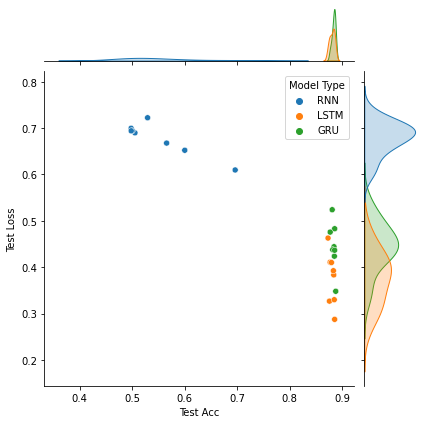

In [1130]:
sns.jointplot(x="Test Acc", y="Test Loss", hue="Model Type", data=df_1, kind="scatter")

### Conclusion of Experiment 1
Overall, the best results are definitely obtained by GRU and LSTM. As the hyper parameters are the same for the smallest loss and the best accuracy, choosing between GRU and LSTM is more of a matter of computation time and preferences than anything else for this task. 

## Experiment 2: Attention
In this experiment, we analyse the effect of adding an attention layer for the sentiment analysis. See Methods section for details of the attention.

In [1131]:
df_2 = pd.read_csv("results/exp2_all.csv")

#### Model
Here, we can more or less make the same conclusion as in experiment 1: GRU and LSTM are better than RNN. However, GRU is able to better reduce the loss in average and RNN performed around 10% less than the others for the accuracy and the loss. RNN shows way better results than before, marking a higher influence of the attention. It's around 20% better. LSTM has seen its loss slightly increase, making GRU now the best for both accuracy and loss.

Comparing with the first experiment, adding attention greatly increase the performance of the RNN which lacks memory but very slightly improve LSTM and GRU which rely on a better memory.

In [1132]:
df_2.groupby("Model Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Model Type,,
GRU,0.886920,0.422186
LSTM,0.883933,0.448550
RNN,0.749907,0.505979


#### Attention type
We can see that, on average, the self attention reaches better results for both accuracy and loss, even if the attention by the last hidden layer gives performances not too far from the first.

The attention mecanism increase the computation time and memory usage, especially for the self-attention mechanism.

In [1133]:
df_2.groupby("Attention").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Attention,,
last_hidden_layer,0.867253,0.442866
none,0.777413,0.540949
self,0.876093,0.392901


<AxesSubplot:xlabel='Attention', ylabel='Test Loss'>

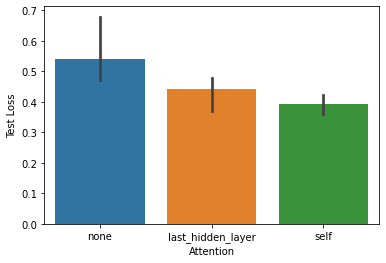

In [1134]:
sns.barplot(x="Attention", y="Test Loss", data=df_2)

#### Validation Loss monitoring
Let us analyse the plot below. We can see that, the loss curve start overfitting at around 3600 steps. The area around is very large. We can see the adding attention lowers the loss. The self-attention layer seems slightly better than the other. It is more stable, tighter around its mean loss and overfits less.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

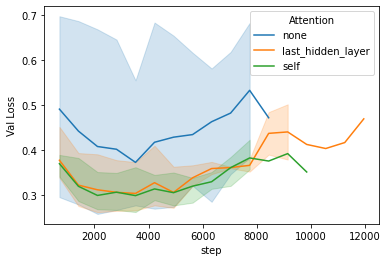

In [1135]:
sns.lineplot(x="step", y="Val Loss", hue="Attention", data=df_2)

#### Full results

Here are the complete results of experiment2.

In [1136]:
df_2.groupby(["Model Type","Attention"], sort=True).max()[["Test Acc", "Test Loss", "step"]]

Test Acc  Test Loss   step
Model Type Attention                                    
GRU        last_hidden_layer   0.89000   0.369427   6336
           none                0.88584   0.473536   6336
           self                0.88492   0.423595   7744
LSTM       last_hidden_layer   0.88392   0.479714   9152
           none                0.88276   0.470518   8448
           self                0.88512   0.395419   7744
RNN        last_hidden_layer   0.82784   0.479456  11968
           none                0.56364   0.678793   7744
           self                0.85824   0.359689   9856

### Conclusion of Experiment 2
Overall, attention improves accuracy at the cost of performance. The best results are obtained with a self attention layer. Attention greatly improves the RNN but GRU and LSTM still outperform it.

## Experiment 3: Word level embedding
In this third experiment, we compare results based on three word level embeddings: GloVe, FastText and Word2Vec.

In [1137]:
df_3 = pd.read_csv("results/exp3_all.csv")

#### Embedding
We can see in the table below that there are not much differences between the performances of the three embeddings. Glove is the one performing better in accuracy, while FastText is the best for the loss.

In [1138]:
df_3.groupby("Embedding").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Embedding,,
FastText,0.86768,0.404606
Glove,0.88456,0.456487
Word2Vec,0.87614,0.420189


<AxesSubplot:xlabel='Embedding', ylabel='Test Loss'>

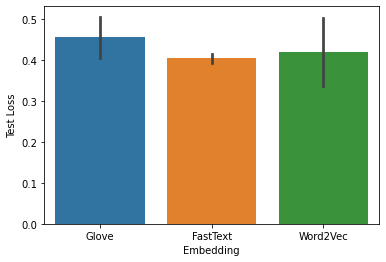

In [1139]:
sns.barplot(x="Embedding", y="Test Loss", data=df_3)

#### Full results
As said before, GRU and LSTM have pretty close results, and this is again the case despite the different embeddings. GloVe combined with LSTM gives the best accuracy with a value of 0.88744, but with also the highest loss in the table. The smallest loss is achieved with LSTM and Word2Vec.

In [1140]:
df_3.groupby(["Model Type","Embedding"], sort=True).max()[["Test Acc", "Test Loss"]]

Test Acc  Test Loss
Model Type Embedding                     
GRU        FastText    0.87404   0.414855
           Glove       0.88744   0.506794
           Word2Vec    0.87744   0.503496
LSTM       FastText    0.86132   0.394357
           Glove       0.88168   0.406180
           Word2Vec    0.87484   0.336882

#### Validation loss monitoring
The first to reach its minimal loss is Glove, with around 3500 steps. The second is FastText at 4000 steps, where the area is really tight. The third is Word2Vec, at around 5500 steps. Word2Vec is spread wider at the beginning than the others. Glove seems to be a good choice here as it combines the fastest computation and reaches the best loss.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

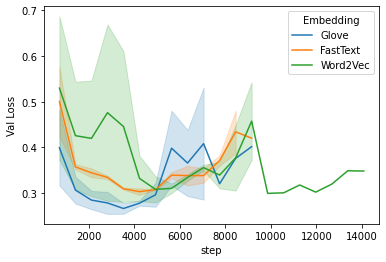

In [1141]:
sns.lineplot(x="step", y="Val Loss", hue="Embedding", data=df_3)

#### Distribution of the loss and the accuracy
We can see that Glove and Word2Vec are highly spread on the loss axis, while less for the accuracy. FastText does exactly the contrary. The more it is spread, the less we can hope to obtain the desired performance. But with the great tuning, Glove can outperform FastText and Word2Vec.

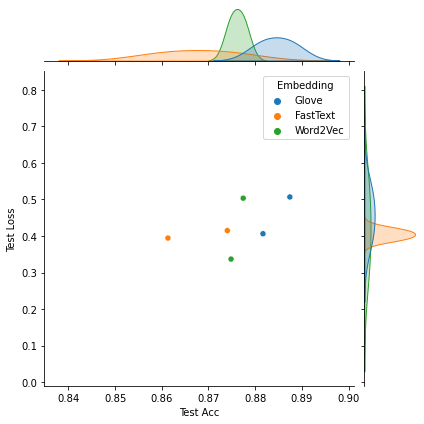

In [1142]:
sns.jointplot(x="Test Acc", y="Test Loss", hue="Embedding", data=df_3, kind="scatter")

### Conclusion of Experiment 3
The performance of the three embeddings are very close. However, Glove seems to stand out more often than the two others along the experiment with respect ot accuracy.

## Experiment 4: Document level embedding

As explained at the top of this report (Methods), we will compare in this expertiment four document level embeddings: from scratch and pretrained average, sentence-BERT and Word Mover's Embedding.

In [1143]:
df_4 = pd.read_csv("results/exp4_all.csv")

#### Model
From the table below, we see that the best embedding between the four is the word embedding average learned from scratch, for both the accuracy and the loss. This can be explained by the embedding being trained specifically for this task and thus being more appropriate. The others present a gap of 4 to 10% of accuracy from the from-scratch-average. That makes them not much interesting as we can expect better results considering the previous experiments. Only comparing embeddings, all those embeddings show performance clearly inferior to the ones of the word embeddings tried in the third experiment with recurent neural networks. 

Note on performances, the BERT sentence embedding and the WME have been pre-encoded before training the classifier. While the BERT sentence can be encoded in few minutes on a GPU, the WME implementation that we used does not use GPU acceleration and took several hours to encode the 50000 sentences of the IMDB dataset.

In [1144]:
df_4.groupby("Model Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Model Type,,
from-scratch-average,0.862396,0.424313
pretrained-average,0.770364,0.500188
sentence-bert,0.822952,0.436322
wme,0.763836,0.496433


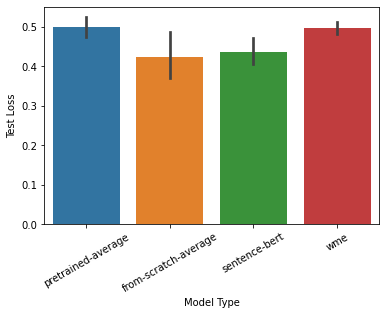

In [1145]:
p = sns.barplot(x="Model Type", y="Test Loss", data=df_4)
for item in p.get_xticklabels():
    item.set_rotation(30)


#### Ouput layer type
Here we can see that an MLP classifier and a linear classifier reach similar accuracies. This may indicate that if some information about the polarity can be extracted, it can be extracted mostly linearly from the sentence embedding. The MLP has a bit higher test loss which indicates overfitting compared to the linear model.

In [1146]:
df_4.groupby("Output Layer Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Output Layer Type,,
MLP,0.803902,0.486118
linear,0.805872,0.442510


#### Validation loss and accuracy monitoring
We can see on the plot below that there is a real distinction of performances: the pretrained average and WME are never able to decrease the loss up to sentence-bert and the average from scratch. This last is the best one for the loss and reaches its minimal value at 2000 steps. However, this task-specific embedding quickly starts to overfit the trainign set. The interpretation is similar for the validation accuracy.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

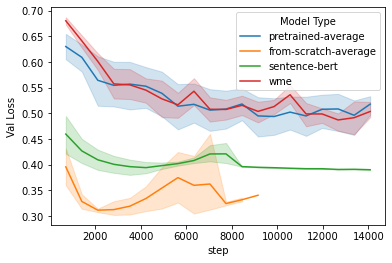

In [1147]:
sns.lineplot(x="step", y="Val Loss", hue="Model Type", data=df_4)

<AxesSubplot:xlabel='step', ylabel='Val Acc'>

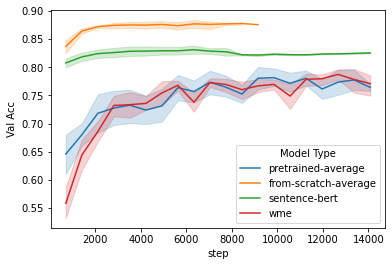

In [1148]:
sns.lineplot(x="step", y="Val Acc", hue="Model Type", data=df_4)

#### Distribution of loss and accuracy
Unlike previous experiments, some distributions now seem to be more multimodal. The advantage of the average from scratch is obvious for the accuracy, while loss is still spread for a given accuracy.

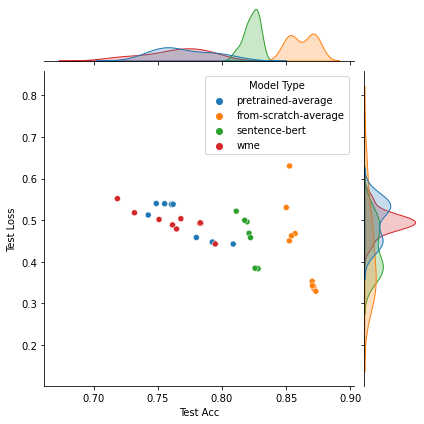

In [1149]:
sns.jointplot(x="Test Acc", y="Test Loss", hue="Model Type", data=df_4, kind="scatter")

#### Full results
We can see from the table here that the average from scratch with a linear output layer is indisputably the best configuration, having the best accuracy with a value of 0.871472 and the smallest loss with 0.340375. However, despite being best in this context, better accuracies and loss have been reached before with word embeddings.

In [1150]:
df_4.groupby(["Model Type","Output Layer Type","Embedding Size"], sort=True).mean()[["Test Acc", "Test Loss"]]

Test Acc  Test Loss
Model Type           Output Layer Type Embedding Size                     
from-scratch-average MLP               300             0.853320   0.508252
                     linear            300             0.871472   0.340375
pretrained-average   MLP               300             0.783368   0.461443
                     linear            300             0.757360   0.538933
sentence-bert        MLP               384             0.818312   0.488791
                     linear            384             0.827592   0.383853
wme                  MLP               300             0.760608   0.485986
                     linear            300             0.767064   0.506880

### Conclusion of Experiment 4
Despite obtaining quite good performances, the word level embedding reached better performance than document level embeddings. Among the document level embedding, the task specific word embedding average learned from scratch obtains the best results. Among the general sentence embeddings, the BERT sentence embedding reached the best results.

## Experiment 5: Performance on different datasets
For this last experiment, we compare the IMDB and Yelp datasets. The IMBD is a binary classification problem and the Yelp dataset has 5 classes.

In [1151]:
df_5 = pd.read_csv("results/exp5_all.csv")
df_5_yelp = df_5[df_5["Dataset"]=="Yelp"]

#### Dataset
The results in the table below leave no doubt: the models reach better results on IMDB than Yelp, by far, for both accuracy and loss.

In [1152]:
df_5.groupby(["Dataset", "Number of Classes"]).mean()[["Test Acc", "Test Loss"]]

,,Test Acc,Test Loss
Dataset,Number of Classes,,
IMDB,2,0.885080,0.276983
Yelp,5,0.624059,0.853510


<AxesSubplot:xlabel='Dataset', ylabel='Test Loss'>

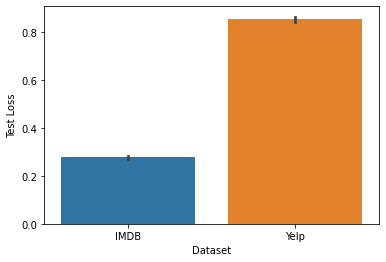

In [1153]:
sns.barplot(x="Dataset", y="Test Loss", data=df_5)

#### Validation Loss monitoring
On top of the performance, we can also notice that the model reaches its minimal loss in a small number of steps on IMDB (~1500) while on Yelp needs more iterations.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

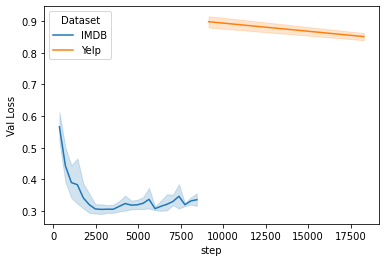

In [1154]:
sns.lineplot(x="step", y="Val Loss", hue="Dataset", data=df_5)

On the Yelp dataset, the GRU is still faster to learn than the LSTM as in previous experiments.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

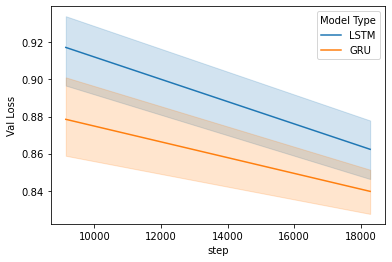

In [1155]:
sns.lineplot(x="step", y="Val Loss", hue="Model Type", data=df_5_yelp)

The attention mechanism made the models slower to learn (iteration-wise) and they were limited by the maximum number of iterations 20000. Therefore they probably did not reach their full potential and the model without attention reached the best loss within 20000 steps.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

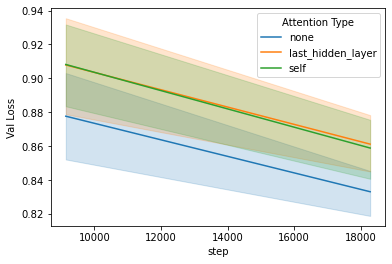

In [1156]:
sns.lineplot(x="step", y="Val Loss", hue="Attention Type", data=df_5_yelp)

With respect to the embeddings, we observe the same results as on the IMDB dataset, the model seems to learn faster with the GloVe embedding.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

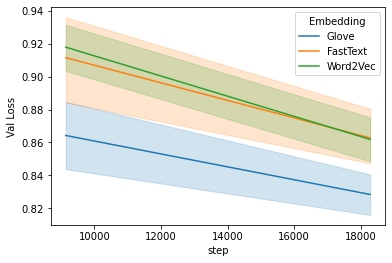

In [1157]:
sns.lineplot(x="step", y="Val Loss", hue="Embedding", data=df_5_yelp)

#### Full results
The binary classification of th IMDB dataset is indeed 'easier' than the multiclass problem of Yelp which requires more nuances. The model did not reach full performance on Yelp due to the limitation on the number of iterations (20000). Compared to the other experiment were the last model was kept, here the best model with respect to the validation loss was kept which explains why the test losses are smaller than in the previous experiments on IMDB.

In [1158]:
df_5.groupby(["Dataset", "Model Type", "Attention Type", "Embedding"], sort=True).max()[["Test Acc", "Test Loss", "step"]]

Test Acc  Test Loss   step
Dataset Model Type Attention Type    Embedding                            
IMDB    GRU        last_hidden_layer FastText    0.88240   0.279783   4576
                                     Glove       0.89272   0.258790   4576
                                     Word2Vec    0.87900   0.289286   5280
                   none              FastText    0.88384   0.278409   4224
                                     Glove       0.89540   0.254885   4224
                                     Word2Vec    0.89152   0.262441   4928
                   self              FastText    0.88300   0.282663   4928
                                     Glove       0.89608   0.255064   4576
                                     Word2Vec    0.88200   0.279407   6336
        LSTM       last_hidden_layer FastText    0.87912   0.296903   5632
                                     Glove       0.88996   0.267317   4928
                                     Word2Vec    0.87812   0.290751   5280
                   none              FastText    0.87968   0.282107   7392
                                     Glove       0.89116   0.268629   5632
                                     Word2Vec    0.88228   0.278673   8448
                   self              FastText    0.87936   0.294642   4928
                                     Glove       0.88992   0.270360   6336
                                     Word2Vec    0.87588   0.295584   8448
Yelp    GRU        last_hidden_layer FastText    0.62398   0.850602  20000
                                     Glove       0.63398   0.837873  20000
                                     Word2Vec    0.61894   0.867054  20000
                   none              FastText    0.62402   0.845560  20000
                                     Glove       0.64690   0.804758  20000
                                     Word2Vec    0.63270   0.833631  20000
                   self              FastText    0.62396   0.854034  20000
                                     Glove       0.63770   0.824435  20000
                                     Word2Vec    0.62328   0.858323  20000
        LSTM       last_hidden_layer FastText    0.59918   0.903041  20000
                                     Glove       0.63172   0.843634  20000
                                     Word2Vec    0.61124   0.881703  20000
                   none              FastText    0.62190   0.855024  20000
                                     Glove       0.63928   0.821824  20000
                                     Word2Vec    0.62576   0.852051  20000
                   self              FastText    0.60680   0.889186  20000
                                     Glove       0.62572   0.849955  20000
                                     Word2Vec    0.60600   0.890489  20000

### Conclusion of Experiment 5
The sentiment analysis task is better achieved on the IMDB dataset which requires less nuances than the multiclass Yelp Reviews.
Overall, the results on Yelp confirms the results obtained on IMDB in terms of word embedding and model types, except for the attention which made the training slower iteration-wise contrary to previous results on IMDB. Whether or not the attention would have brought better accuracy at convergence as on IMDB would have required longer training.

## Conclusion
Thanks to those experiments, we can say that there is not much difference in the performances of GRU and LSTM, but the GRU seems to converge faster in terms of number of iterations. Adding attention was not that efficient as it takes more computation time for slightly better performances. We also saw that the GloVe embedding seemed better for the word level embeddings, and that the "average from scratch" embedding was the best for document level embeddings. Between word level embeddings and document level embeddings, the first one yielded to better results. Finally, the results obtained on IMDB were moslty confirmed by our experiment on the multiclass Yelp reviews dataset.

## Bibliography

- Nils Reimers and Iryna Gurevych (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. CoRR, abs/1908.10084.
- Lingfei Wu and Ian En-Hsu Yen and Kun Xu and Fangli Xu and Avinash Balakrishnan and Pin-Yu Chen and Pradeep Ravikumar and Michael J. Witbrock (2018). Word Mover's Embedding: From Word2Vec to Document Embedding. CoRR, abs/1811.01713.
- Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies (pp. 142–150). Association for Computational Linguistics.
- Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735-1780.
- Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, & Yoshua Bengio. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. (2014). GloVe: Global Vectors for Word Representation. 
- Grave, E., Bojanowski, P., Gupta, P., Joulin, A., & Mikolov, T. (2018). Learning Word Vectors for 157 Languages. In Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018).
- Tomas Mikolov, Kai Chen, Greg Corrado, & Jeffrey Dean. (2013). Efficient Estimation of Word Representations in Vector Space. 
- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, & Illia Polosukhin. (2017). Attention Is All You Need. 

